In [99]:
%run 'testSkeleton_OQE_Functions.ipynb'

In [100]:
s = 120
nu_max, nu_min = 120, 100 # MHz units
inprange = nu_max - nu_min
nu_ = np.linspace(nu_min,nu_max,s)
nu, nup = np.meshgrid(nu_,nu_)
tau_ = np.fft.fftfreq(s, (nu_max-nu_min)/(s-1))
tau_f = flip(tau_)
print(tau_f[0:5])

[-2.975      -2.92541667 -2.87583333 -2.82625    -2.77666667]


In [101]:
from scipy import linalg
from scipy.stats import invgamma
import pyuvdata as uvd
uvobj = uvd.UVData()

In [5]:
FO = FOp(s)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


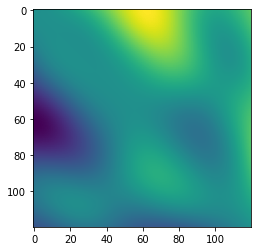

In [132]:
at1,at2 = 0,3
simfile = '/home/kennedy/sims/viscatBCpoints.uvh5'
faintfile = '/home/kennedy/sims/viscatBC15jy.uvh5'
oldsimfile = '/home/kennedy/sims/600times/viscatBCpoints.uvh5'
oldeorfile = '/home/kennedy/sims/600times/viscatBCeor.uvh5'
ats = (at1, at2)

uvobj.read(simfile)
bl = uvobj.get_data(ats)
C_f = np.cov(bl.T)
uvobj.read(oldsimfile)
bl6 = uvobj.get_data(ats)
C_f6 = np.cov(bl6.T)
uvobj.read(oldeorfile)
eor = uvobj.get_data(ats)
C_eor = np.cov(eor.T)
uvobj.read(faintfile)
blfaint = uvobj.get_data(ats)
C_faint = np.cov(blfaint.T)
plt.imshow(C_f.imag)

In [133]:
rfi2 = np.load('rfi2.npy')
rfi5 = np.load('rfi5.npy')
rfi10 = np.load('rfi10.npy')

w0,w1,w2,w3 = np.ones((s,)),np.ones((s,)),np.ones((s,)),np.ones((s,))
w1[rfi2],w2[rfi5],w3[rfi10] = 0,0,0

wc1,wc2,wc3 = np.ones((s,)),np.ones((s,)),np.ones((s,))
wc1[40:42], wc2[40:46], wc3[40:52] = 0,0,0 

In [134]:
SNR = 3
As, ws, k = 25e-2, 0.5, 25e-3/SNR
gc = As/1e1

C_signal = (gc*np.eye(s) + As * np.exp( -(nu-nup)**2 / ws**2  )) 
C_sig_delay = np.eye(s) * np.diag((FO @ C_signal @ FO.T.conj()).real)
C_signalcirc = (FO.T.conj()@ C_sig_delay @ FO).real / s**2

C_noise = k * np.eye(s) 

S = C_signal+C_f
N = C_noise
mv = np.zeros(s)
R = np.diag(BH(s))

In [9]:
# plt.matshow(np.log10(C_signalcirc))
# plt.colorbar()

In [135]:
Np = 1200 # number of data

truesigs = nsample(mv, C_signalcirc, Np)

# signaltouse = eor
signaltouse = truesigs

Vft = bl[:Np] + signaltouse 

noiseS = (nsample(mv, C_noise, Np) + 1j*nsample(mv, C_noise, Np))/2**0.5
Vis_noise = Vft + noiseS # noisy data generated

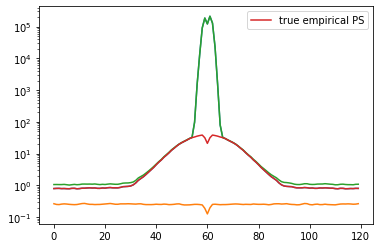

In [136]:
# signal and noise spectra for later comparison
pS = naivePS(Vft, meansub=1, taper=1)
pSsig = naivePS(signaltouse, meansub=1, taper=1)

# true (empirical) power spectrum - mean over signal power spectra
tps = np.mean(pSsig, axis=0).real

pSnoise = naivePS(noiseS, meansub=1, taper=1)
pSdata = naivePS(Vis_noise, meansub=1, taper=1)
plt.plot(np.mean(pS, axis=0))
plt.plot(np.mean(pSnoise, axis=0))
plt.plot(np.mean(pSdata, axis=0))
plt.plot(tps, label='true empirical PS')
plt.yscale('log')
plt.legend()

In [12]:
def sample_S(s=None, sk=None, prior=None):
    """
    Draw samples of the bandpowers of S, p(S|s). This assumes that the conditional 
    distribution for the bandpowers are uncorrelated with one another, i.e. the Fourier-
    space covariance S has no off-diagonals.
    
    Parameters:
        s (array_like):
            A set of real-space samples of the field, of shape (Ntimes, Nfreq).
    """
    if s is None and sk is None:
        raise ValueError("Must pass in s (real space) or sk (Fourier space) vector.")

    if sk is None:
        sk = np.fft.fft(s, axis=-1) 
    Nobs, Nfreqs = sk.shape
    
    beta = np.sum(sk * sk.conj(), axis=0).real 
    
    alpha = Nobs/2. - 1.
    
    x = np.zeros(Nfreqs)
    for i in range(Nfreqs):
        x[i] = invgamma.rvs(a=alpha) * beta[i] # y = x / beta
    
    
    
    if prior is not None:
        for i in range(Nfreqs):
            if prior[0,i] ==0: continue
            else: 
                if x[i] > prior[0,i]:  x[i] = prior[0,i]
                if x[i] < prior[1,i]:  x[i] = prior[1,i]
                    
    return x

In [115]:
def sprior(signals, bins, factor):
    
    # bins - number of bins past zero delay to take, either side. e.g. bins=2 takes delays [-2,-1,0,1,2] from centre
    # factor is maximum factor to multiply / divide the truth by
    
    Nobs,Nfreq = signals.shape

    ds = nPS(signals)
    
#     sk = np.fft.fft(signals, axis=-1) # changed after prior looked a bit off, 1 part in 10^5
#     ds = np.sum(sk * sk.conj(), axis=0).real
    
    prior = np.zeros((2,Nfreq))
    
    prior[0] = ds*factor
    prior[1] = ds/factor
    
    prior[0,bins+1:-bins] = 0
    prior[1,bins+1:-bins] = 0
    
    return prior/(Nobs/2 -1)

In [116]:
def GCR_eig(dat, w, matlib, F_evecs, f0=None, amps=None):
    """
    
    GCR w/ fitted eigenmodes of C_foreground
    
    matlib[0]: Sh = sp.linalg.sqrtm( S ) ... etc.
    Si = np.linalg.inv( S )
    Ni = w.T*np.linalg.inv( N )*w
    Sih = sp.linalg.sqrtm( Si )
    Nih = sp.linalg.sqrtm( Ni )
    
    """
    s = F_evecs.shape[0]
    fvs = F_evecs.shape[1]
        
    d = dat.reshape((1,max(s,len(dat.T))))

    Sh = matlib[0][0]
    Si = matlib[0][1]
    Ni = matlib[0][2]
    Sih = matlib[0][3]
    Nih = matlib[0][4]
    A = matlib[1][0]
    Ai = matlib[1][1]
            
    omi, omj = np.random.randn(s,1),np.random.randn(s,1)
    omk, oml = np.random.randn(s,1),np.random.randn(s,1)
    oma, omb = (omi+1j*omj)/2**0.5 , (omk+1j*oml)/2**0.5

    b = np.zeros((s+fvs,1), dtype=complex)

    b[:s] = Ni @ (w*d).T + Sih@oma + Nih @ omb
    b[s:] = F.T.conj() @ (Ni @ (w*d).T + Nih @ omb) 
    
    if f0 is not None:
        xboth, info2 = conjgrad(A, b, maxiter=1e5, x0=np.concatenate((np.zeros(s,dtype=complex),f0)), M=Ai)
    else: 
        xboth, info2 = conjgrad(A, b, maxiter=1e5, M=Ai)
        
    sig_sol = xboth[:s]
    fg_sol = xboth[s:] @ F.T            

    sol = sig_sol + fg_sol
       

    if amps==True: return xboth
    else: return sig_sol

In [117]:
def makeS(delayspec):
    
    N_freq = delayspec.size
    
    C_sigfft = np.zeros((N_freq, N_freq), dtype=complex)
    
    for i in range(N_freq):
        C_sigfft[i,i] = delayspec[i]
        
    C_sig = (FO.T.conj() @ C_sigfft @ FO).real
    
    return C_sig
    

In [118]:
def GCR_eigarray(V, w, matlib, F_evecs, f0=None, ncpu=2, amps=None):
    
    if amps: VC = np.zeros((V.shape[0],V.shape[1]+F_evecs.shape[1]), dtype=complex)
    else: VC = np.zeros(V.shape, dtype=complex)

    Vidxs = np.arange(V.shape[0])
    
    st=time.time()
    with Pool(ncpu) as pool:
        VC = pool.map(lambda idx: GCR_eig(V[idx], w, matlib, F_evecs, f0=f0, amps=amps), Vidxs)

    print('%.1fs'%(time.time()-st), end=' ')
    if amps: return np.array(VC).reshape((V.shape[0],-1))
    else: return np.array(VC).reshape(V.shape)

In [137]:
Sevals, Sevs = np.linalg.eig(C_f) # CHANGED FROM C_F!!!!!
Nf = 12
F = Sevs[:,:Nf]

In [ ]:
# cr_eig = GCR_eig(Vis_noise[0], w0, C_signal, F, N)
# ___, cr_st = GCR(Vis_noise[0], w0, S, N, nrzn=1, inpaint=None)

In [ ]:
crs = GCR_eigarray(Vis_noise, wc3, C_signalcirc, F, N)

In [ ]:
ds_sample = sample_S(s=crs) 

In [ ]:
# factors = np.linspace(7.8961097667,7.8961097668, 100)
# plt.plot([np.sum( np.mean(naivePS(crs, meansub=1, taper=1), axis=0) - flip(ds_sample)/factor) for factor in factors])
fact=7.8961097668

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
plt.plot(np.mean(pS, axis=0), label='inital foreground + signal')
plt.plot(np.mean(naivePS(crs, meansub=1, taper=1), axis=0), label='mean PS of GCR sols.')
plt.plot(flip(ds_sample)/fact, label='inv-gamma sample')
plt.plot(np.mean(pSnoise,axis=0), 'k--',label='noise', alpha=0.5, lw=1.2)

plt.yscale('log')
plt.legend(frameon=False, fontsize=13)

In [ ]:
Csamp = makeS(ds_sample/(2*120**2))

# for i in range(120):
#     for j in range(120):
#         if abs(i-j) > 80: Csamp[i,j] = 0

plt.imshow(np.log10(Csamp), vmin=-4, vmax=0)   # divide by factor of 2 * N_freq^2
plt.colorbar()
plt.show()
plt.imshow(np.log10(C_signal), vmin=-4, vmax=0)
plt.colorbar()
print(C_signal[0,119])
print(Csamp[0,119])



In [119]:
def Gibbs_eig_step(vis, S, F_evecs,  N, flags, f0=None, amps=None, prior=None, ncpu=2):
    
    Nvis,Nfreq = vis.shape
    
    fvs = F_evecs.shape[1]
    A_l = int(s + fvs) 
    
    matlib = [0,0]
    matlib[0] = np.zeros((5,Nfreq,Nfreq),dtype=complex)
    matlib[1] = np.zeros((2,A_l,A_l),dtype=complex)

    matlib[0][0] = sp.linalg.sqrtm( S ) # Sh
    matlib[0][1] = np.linalg.inv( S )   # Si
    matlib[0][2] = flags.T*np.linalg.inv( N )*flags # Ni
    matlib[0][3] = sp.linalg.sqrtm( matlib[0][1] )  # Sih
    matlib[0][4] = sp.linalg.sqrtm( matlib[0][2] )  # Nih
    
    A = np.zeros((A_l, A_l), dtype=complex)
    A[:s,:s] =  matlib[0][1] + matlib[0][2]  # Si + Ni
    A[:s,s:] = matlib[0][2] @ F_evecs     
    A[s:,:s] =  F_evecs.T.conj() @ matlib[0][2]  
    A[s:,s:] = F_evecs.T.conj() @ matlib[0][2] @ F_evecs

    matlib[1][0] = A
    matlib[1][1] = np.linalg.inv(A)
    
    cr = GCR_eigarray(vis, flags, matlib, F_evecs, f0=f0, ncpu=ncpu, amps=amps)
    if amps: 
        amplitudes = cr[:,-F_evecs.shape[1]:]
        cr = cr[:,:-F_evecs.shape[1]]
    
    ds_sample = sample_S(s=cr, prior=prior)
    
    Snew = makeS(ds_sample/(2*Nfreq**2)) # divide by factor of 2 * N_freq^2
    
    if amps: return cr, Snew, ds_sample, amplitudes
    else: return cr, Snew
    

In [138]:
Niter = 2000

np.random.seed()

name = 'run13'
savfol = 'Gibbs-eig-runs/'

# initial 3 was pretty nice! definitely usable
# initial 4 now beginning with circulant matrix, a little different and worth looking at
# initial 5 running for 1k iters to make covariance over sampled vals
# initial 6 running with 5% cont. flag
# initial 7 2000 iters with 5% cont. flag, stopped at 1372
# initial 8 attempt with eor sims 400 iters
# initial 9 eor sims again, 200 iters, 12 eigenvectors
# initial 10 back on gaussian signal, 100 iters very low noise no flags - any oscillations? NONE! (or, at the 0.001% level)
# initial 11 100 iters. slightly less low noise, no flags - now has oscillations
# initial 12 600 iters - 5% flag normal noise, priors, x0=f0 - testing prior
# initial 13 400ix1200 as above but no ds prior, testing matlib - 
# initial 14 400iX1200 testing x0=f0, matlib, no dsprior - x0=f0 messed it up?
# initial 15 200ix1200 removed x0=f0, does that improve things - yes

# run1 - 1500ix1200, random 5% flag, hard prior - comparison to joint sampling: very nice, actually! not travelling
# run2 - 800ix1200 - paper run
# run3 - 800    10% cont run
# run4 - ''     5% cont.   SNR 5/1 - 
# run5 - ''     no flag    SNR 5/1 - 
#####
# run6 - ''     5% rand.   SNR  30/1- some larger scale oscillations in the recovery
# run7 - ''     none       SNR  30/1- delay spectrum has fewer oscillations
# run8 - ''     none       SNR   3/1- 
# run9 - ''     none       SNR 0.5/1-
# run-- ''     5% random  SNR   5/1- [prior is 1.5x too large]
# run10- ''     no flag    SNR   3/1- USING CFAINT! change back after (above under def eigarray,C_faint to C_f)
# run11- ''     5% r       SNR   3/1 - antenna 0,3 - longest baseline? result looks good but need +prior region size
# run12- ''     ''         ''        - antenna 0,4 - diff orientation?
# run13- ''                          - antenna 0,3 12 emodes 2k iters bins=4 prior   

cr_store = np.zeros((Niter,Np,120), dtype=complex)
S_store = np.zeros((Niter,120,120))
ds_store = np.zeros((Niter,120))
amp_store = np.zeros((Niter,Np,Nf),dtype=complex)

flagging = w1

# f0 = F.T.conj() @ np.mean(bl, axis=0)
f0 = None
dsprior = sprior(signaltouse, bins=4, factor=1) # prior, bins=2 fac=2 -> 5 central delays, up or down by a factor of 2
# dsprior = None

cr_store[0],S_store[0],ds_store[0],amp_store[0] = Gibbs_eig_step(Vis_noise*flagging, C_signalcirc, F, N, flagging, f0=None, amps=True,prior=dsprior)

np.save(savfol+'truesigs-'+name+'.npy',signaltouse)
np.save(savfol+'noise-'+name+'.npy',noiseS)

for i in range(Niter-1):
    
    print('IT#%d'%(i+1),end=', ')
    
    cr_store[i+1] , S_store[i+1],ds_store[i+1],amp_store[i+1] = Gibbs_eig_step(Vis_noise*flagging, S_store[i], F, N, flagging, f0=None, amps=True,prior=dsprior)

#     if not i%500:               # saving every 500 iters for longer runs
#         np.save(savfol+'cr-'+name+'.npy',cr_store)
#         np.save(savfol+'S-'+name+'.npy',S_store)
#         np.save(savfol+'ds-'+name+'.npy',ds_store)
#         np.save(savfol+'amps-'+name+'.npy',amp_store)

np.save(savfol+'cr-'+name+'.npy',cr_store)
np.save(savfol+'S-'+name+'.npy',S_store)
np.save(savfol+'ds-'+name+'.npy',ds_store)
np.save(savfol+'amps-'+name+'.npy',amp_store)

0.8s IT#1, 0.8s IT#2, 0.9s IT#3, 0.8s IT#4, 1.0s IT#5, 0.8s IT#6, 1.0s IT#7, 0.8s IT#8, 0.9s IT#9, 0.8s IT#10, 0.8s IT#11, 0.8s IT#12, 0.8s IT#13, 0.8s IT#14, 0.8s IT#15, 0.8s IT#16, 0.8s IT#17, 0.9s IT#18, 0.9s IT#19, 0.8s IT#20, 0.9s IT#21, 0.8s IT#22, 0.9s IT#23, 0.8s IT#24, 0.8s IT#25, 0.8s IT#26, 0.8s IT#27, 0.8s IT#28, 0.9s IT#29, 0.8s IT#30, 0.8s IT#31, 0.9s IT#32, 0.9s IT#33, 0.9s IT#34, 0.8s IT#35, 0.8s IT#36, 0.9s IT#37, 0.9s IT#38, 0.8s IT#39, 0.8s IT#40, 0.8s IT#41, 0.8s IT#42, 0.8s IT#43, 0.9s IT#44, 0.7s IT#45, 0.8s IT#46, 0.9s IT#47, 0.8s IT#48, 0.9s IT#49, 0.8s IT#50, 0.8s IT#51, 0.8s IT#52, 0.9s IT#53, 0.8s IT#54, 0.8s IT#55, 0.9s IT#56, 0.8s IT#57, 0.8s IT#58, 1.0s IT#59, 0.9s IT#60, 0.8s IT#61, 0.9s IT#62, 0.9s IT#63, 0.9s IT#64, 0.9s IT#65, 0.8s IT#66, 0.9s IT#67, 0.9s IT#68, 0.8s IT#69, 0.8s IT#70, 0.9s IT#71, 0.9s IT#72, 0.8s IT#73, 0.9s IT#74, 0.8s IT#75, 0.9s IT#76, 0.8s IT#77, 0.9s IT#78, 0.8s IT#79, 0.9s IT#80, 0.9s IT#81, 0.8s IT#82, 0.8s IT#83, 0.8s IT#84, 0

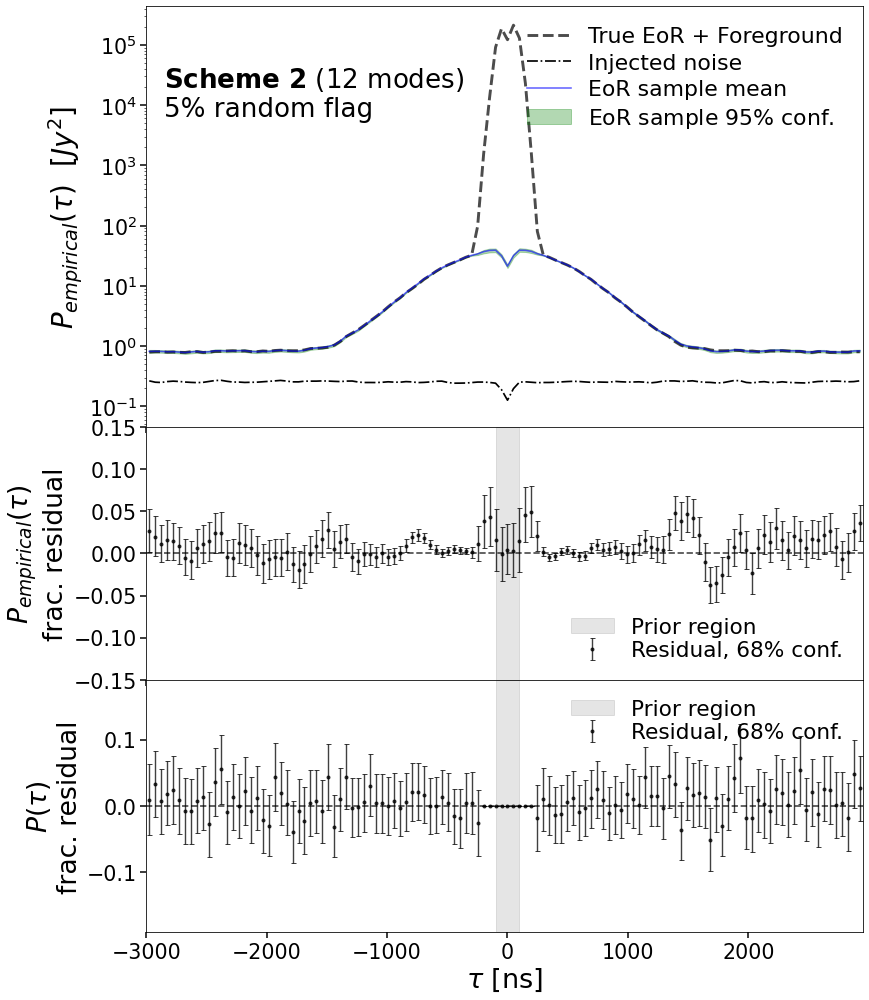

In [139]:
Niter=2000
flagtag = '5% random flag'
# flagtag = 'No flag'
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,14), sharex=True, gridspec_kw={'hspace':0, 'height_ratios':[1,0.6,0.6]})

fsb = 8.1
lwb = 0.5

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + Foreground', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'EoR sample 95$\%$ conf.')

erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')

erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

ax1.legend(frameon=False, fontsize=13.9+fsb, labelspacing=0.3, loc='upper right')
ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower right')
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='upper right')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(length=6, width=1.5, labelsize=12.5+fsb)

ax1.text(-2850,2e4, r'$\bf{Scheme~2}$ (%d modes)'%F.shape[1], fontsize=18+fsb)
ax1.text(-2850,6.45e3, flagtag, fontsize=18+fsb)

ax1.set_ylabel(r'$P_{empirical}(\tau) ~~[Jy^2]$', fontsize=19.5+fsb)
ax2.set_ylabel(r'$P_{empirical}(\tau)$' +'\n' + 'frac. residual', fontsize=18.5+fsb)
ax3.set_ylabel(r'$P(\tau)$' +'\n' + 'frac. residual', fontsize=18.5+fsb)
ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(length=6, width=1.5, labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)
plt.tight_layout()

ax1.set_ylim( 4.5e-2, None)
# ax1.text(-2850,2e2, r'$\bf{15Jy~point~source~cut}$', fontsize=15+fsb)
# plt.savefig('figs/Gibbs/0-3-em-faint.pdf')

# plt.savefig('figs/Gibbs/5r-5-em.pdf')

plt.savefig('figs/Gibbs/longbaseline2.pdf')


In [97]:
name = 'run10'
savfol = 'Gibbs-eig-runs/'
cr_store = np.load(savfol+'cr-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
amp_store = np.load(savfol+'amps-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
pSnoise = naivePS(noiseS)

# Niter=cr_store.shape[0]

In [342]:
cr_store.shape

(800, 1200, 120)

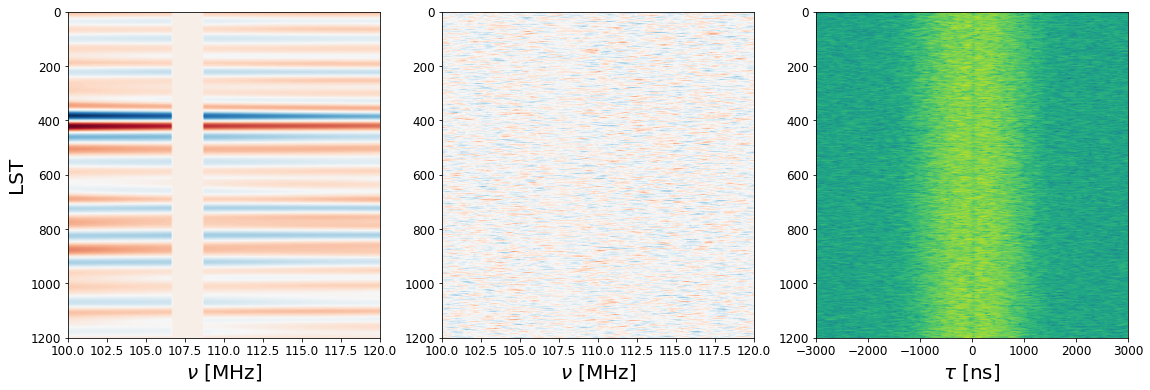

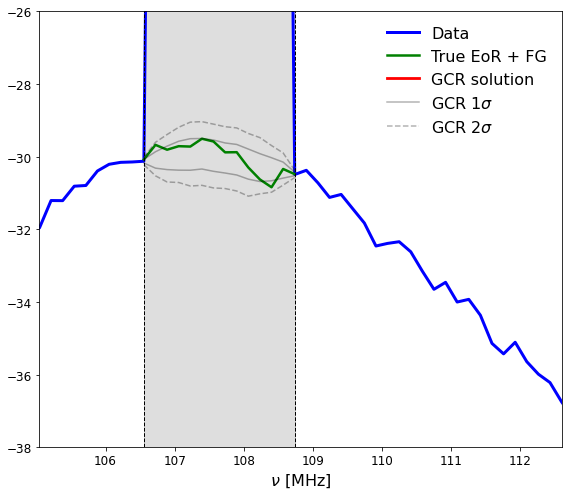

Text(0.5, 0, '$\\tau$ [ns]')

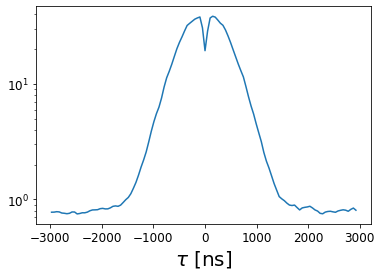

In [498]:
# waterfall, first iteration (using correct covariance)

# flagged data first, then inpainted data

# plot the flagged data as a waterfall

farr = range(39,53)

Vtrue = signaltouse + bl 

Vdat = (signaltouse + bl + noiseS)*wc3

# Vinp = cr_store[0,:] + amp_store[0,:]@F.T
Vinp = cr_store[0,:] 


Vinp_m = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 50, axis=0)
Vinp_1a = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 84, axis=0)
Vinp_1b = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 16, axis=0)
Vinp_2a = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 98, axis=0)
Vinp_2b = np.percentile( (cr_store + amp_store@F.T)[:,0,:], 2, axis=0)


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(19,6), gridspec_kw={'hspace':0.12})
im1 = ax1.imshow(Vdat.real, aspect='auto', cmap='RdBu', extent=(100,120,1200,0))
im2 = ax2.imshow(Vinp.real, aspect='auto', cmap='RdBu', extent=(100,120,1200,0))
im3 = ax3.imshow(np.log(naivePS(Vinp, meansub=1, taper=1)), aspect='auto', cmap='viridis', extent=(-3000,3000,1200,0))
ax1.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax2.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=20)
ax1.set_ylabel('LST', fontsize=20)
# plt.colorbar(im1, ax=ax1, shrink=0.8)
# plt.colorbar(im2, ax=ax2, shrink=0.8)
for ax in [ax1,ax2, ax3]:
    ax.tick_params(labelsize=12)
# ax1.set_title('Flagged Data', fontsize=20)
# ax2.set_title('1 iteration: GCR solution', fontsize=20)
# plt.tight_layout()
plt.savefig('figs/Gibbs/waterfalleor.pdf', bbox_inches='tight')

# now let's look at an individual visibility

plt.show()
fig,ax=plt.subplots(figsize=(8,7))
plt.plot(nu_, Vdat.real[0], lw=3, label='Data', c='b')
plt.plot(nu_[farr], Vtrue.real[0][farr], lw=2.5, label='True EoR + FG', c='g')
# plt.plot(Vinp.real[0], lw=2.5, label='single GCR solution', ls='--')
plt.plot(nu_[farr], Vinp[0][farr].real, c='r', lw=2.8, label='GCR solution')
plt.plot(nu_[farr], Vinp_1a[farr].real, c='k', alpha=0.3, lw=1.5, label=r'GCR 1$\sigma$')
plt.plot(nu_[farr], Vinp_1b[farr].real, c='k', alpha=0.3,  lw=1.5)
plt.plot(nu_[farr], Vinp_2a[farr].real, c='k', alpha=0.3,  ls='--',lw=1.5, label=r'GCR 2$\sigma$')
plt.plot(nu_[farr], Vinp_2b[farr].real, c='k', alpha=0.3,  ls='--',lw=1.5)

# plt.plot(Vinp_av.real[0], lw=2.5, label='Mean EoR sample', ls='--')


plt.axvline(nu_[39], ls='--', c='k', lw=1)
plt.axvline(nu_[52], ls='--', c='k', lw=1)
plt.axvspan(nu_[39],nu_[52],color='k', alpha=0.13)
ax.tick_params(labelsize=12)
plt.xlim(nu_[30],nu_[75])
plt.ylim(-38, -26)
plt.legend(frameon=False, fontsize=16)
plt.xlabel(r'$\nu$ [MHz]', fontsize=16)
plt.tight_layout()
plt.savefig('figs/Gibbs/inpaint.pdf')
plt.show()

plt.plot(tau_f*1e3, np.mean(naivePS(Vinp, meansub=1, taper=1), axis=0))
plt.yscale('log')
plt.tick_params(labelsize=12)
plt.xlabel(r'$\tau$ [ns]', fontsize=20)

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


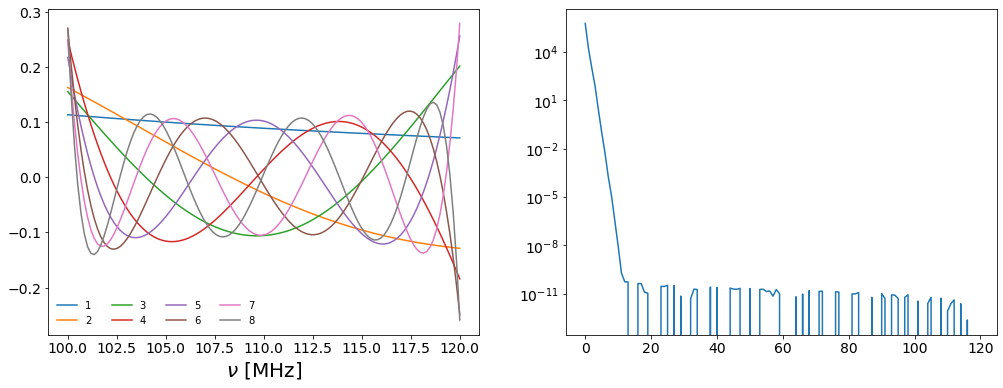

In [483]:
### plt.subplots(figsize=(12,8))
fig, (ax1,ax2) =plt.subplots(1,2, figsize=(17,6), gridspec_kw={'hspace':0.05})
for i in range(8):
    ax1.plot(nu_, F[:,i], label='%d'%(i+1))
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax1.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax1.legend(frameon=False, fontsize=10, ncol=4)
ax2.plot(Sevals)
ax2.set_yscale('log')

plt.savefig('figs/Gibbs/eigenmodes.pdf')

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


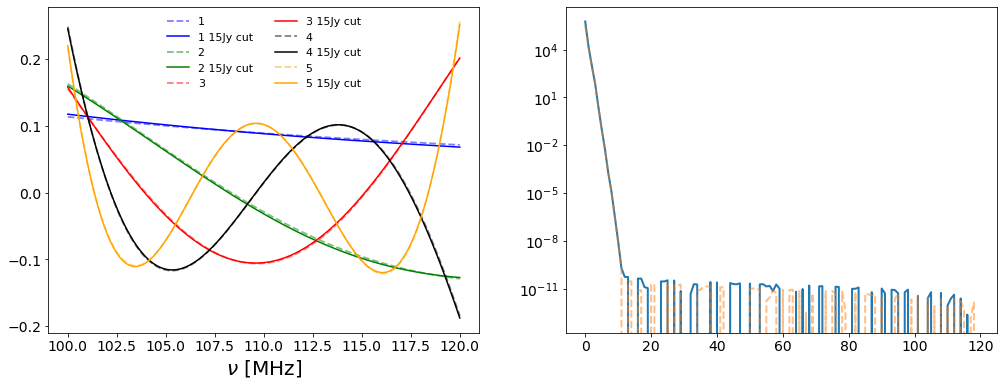

In [497]:
Sevals_f, Sevs_f = np.linalg.eig(C_faint) # CHANGED FROM C_F!!!!!
Nf = 8
F_faint = Sevs_f[:,:Nf]

fcols = ['b', 'g', 'r', 'k', 'orange']

fig, (ax1,ax2) =plt.subplots(1,2, figsize=(17,6), gridspec_kw={'hspace':0.05})
for i in range(5):
    ax1.plot(nu_, F[:,i], label='%d'%(i+1), alpha=0.5, lw=1.8,  ls='--', c=fcols[i])
    ax1.plot(nu_, F_faint[:,i], label='%d 15Jy cut'%(i+1), c=fcols[i])
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax1.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax1.legend(frameon=False, fontsize=11, ncol=2)
ax2.plot(Sevals, lw=2)
ax2.plot(Sevals_f, ls='--', alpha=0.5, lw=2)
ax2.set_yscale('log')

plt.savefig('figs/Gibbs/fainteigenmodes.pdf')

In [ ]:
### plt.subplots(figsize=(12,8))
fig, (ax1,ax2) =plt.subplots(1,2, figsize=(17,6), gridspec_kw={'hspace':0.05})
for i in range(8):
    ax1.plot(nu_, F[:,i], label='%d'%(i+1))
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax1.set_xlabel(r'$\nu$ [MHz]', fontsize=20)
ax1.legend(frameon=False, fontsize=10, ncol=4)
ax2.plot(Sevals)
ax2.set_yscale('log')

plt.savefig('figs/Gibbs/eigenmodes.pdf')

In [ ]:
# trace plots to determine where it has converged
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(9,15))

for i in range(8):
    amptrace = np.sum(amp_store[:1300,:,i], axis=1).real
    ax1.plot(amptrace/amptrace[0], label='fg amp %d'%i,alpha=0.5)
    ampcorr = np.correlate(amptrace-np.mean(amptrace),amptrace-np.mean(amptrace),mode='full')
    ax2.plot(ampcorr/max(ampcorr), label='%d'%i)
# plt.yscale('log')
ax1.legend()
ax2.legend()

In [ ]:
# trace plots to determine where it has converged
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15))
traceidx =0
for idx in [0,1,2,3,4,5]:
    trace = ds_store[:,idx]
    ax1.plot(trace/trace[0], label='%d-delay PS'%idx)
    corr = np.correlate(trace-np.mean(trace),trace-np.mean(trace), mode='full')
    ax2.plot(corr/max(corr), label='%d'%idx)
    
# plt.plot(np.sum(crf_store[:,:,1], axis=1), label='fg amp')
# plt.yscale('log')
# plt.yscale('log')
ax1.legend()
ax2.legend()

In [ ]:
# let;s look at some of these foregrounds

fgamps = amp_store[:Niter,:,:]

print(fgamps.shape)

ampi = fgamps[1299,0]

plt.plot( ampi@F.T )
plt.plot(bl[0])
plt.plot(Vis_noise[0])

In [ ]:
crt = cr_store[:,0,:] # iteration, LST, frequency
print(crt.shape)
plt.plot(crt.T.real)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,11))
ds_store.shape
np.sum(amp_store, axis=1).shape
covmax = 1e50
im = ax1.matshow(np.cov(ds_store.T, np.sum(amp_store, axis=1).T).real, cmap='RdBu', vmin=-1*covmax, vmax=covmax)
im2 = ax2.matshow(np.cov(ds_store.T, np.sum(amp_store, axis=1).T).imag, cmap='RdBu', vmin=-1*covmax, vmax=covmax)

plt.colorbar(im, ax=ax1, shrink=0.6)
plt.colorbar(im2, ax=ax2, shrink=0.6)

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

plt.plot(Vis_noise[0].real)
plt.plot(Vis_noise[0].imag)

plt.plot(cr_eig.real.T, ls='--', alpha=0.7, label='cr')
plt.plot(cr_eig.imag.T, ls='--', alpha=0.7, label='cr')

# plt.plot(cr_st.real.T, ls='--', alpha=0.7, label='cr')
# plt.plot(cr_st.imag.T, ls='--', alpha=0.7, label='cr')
plt.legend()

## Why doesn't this work out?

In [ ]:
dat = Vis_noise[0]
wt = np.ones(s)

fvs = F.shape[1]

d = dat.reshape((1,max(s,len(dat.T))))

Sh = sp.linalg.sqrtm( C_signal )
Nh = sp.linalg.sqrtm( N )
Si = np.linalg.inv( C_signal )
Ni = wt.T*np.linalg.inv( N )*wt
Sih = sp.linalg.sqrtm( Si )
Nih = sp.linalg.sqrtm( Ni )

A_l = int(s + fvs)  
A = np.zeros((A_l, A_l), dtype=complex)

Shb = np.eye(A_l, dtype=complex)
Shb[:s,:s] = Sh

# A[:s,:s] =  np.eye(s) + Sh @ Ni @ Sh
A[:s,:s] =  Si + Ni 
A[:s,s:] = Ni @ F     
A[s:,:s] =  F.T.conj() @ Ni  
A[s:,s:] = F.T.conj() @ Ni @ F



print('Block hermitian -', np.allclose(A,A.T.conj()))
Ai = np.linalg.inv(A)
plt.imshow(A.real)

In [ ]:
omi, omj = np.random.randn(s,1),np.random.randn(s,1)
omk, oml = np.random.randn(s,1),np.random.randn(s,1)
oma, omb = (omi+1j*omj)/2**0.5 , (omk+1j*oml)/2**0.5

b = np.zeros((A_l,1), dtype=complex)
bw = np.zeros((A_l,1), dtype=complex)

b[:s] = Ni @ (wt*d).T + Sih@oma + Nih @ omb
# b[:s] = Sh @ Ni @ (wt*d).T + oma + Sh @ Nih @ omb
b[s:] = F.T.conj() @ (Ni @ (wt*d).T + Nih @ omb) 

xboth, info2 = conjgrad(A, b, maxiter=1e5, M=Ai)


# sig_sol = (Shb@xboth)[:s]
sig_sol = xboth[:s]
fg_sol = xboth[s:] @ F.T            

sol = sig_sol + fg_sol


In [ ]:
plt.plot(sig_sol.real, label='signal solution')
plt.plot(truesigs[0].real, label='true signal')
# plt.plot(truesigs[0])
plt.plot(sol.real, label='gcr (total) solution')
plt.plot(dat.real, label='data')
# plt.plot(sig_solw.real, label='wiener filter') # why is this weird?
plt.legend()


In [ ]:
# is the change of basis matrix method worth looking into? how does performance compare to eigenmode fitting?

# why does the schur complement have the form it does? in what way is it the conditional covariance?

# tasks - 
# try out an Sh implementation

# continue coding to create the second Gibbs sampler

# run it for 100+ steps

# update Phil

In [ ]:
# SO
# Gibbs sampler with foreground components -> up to runs
# inv-wishart comparison from R
# update Phil
# set off batches of 20 runs with different random seeds for the no flags/ low noise cases, over the weekend

# NEXT WEEK
# read and comment on Mike's paper
# think about the maths for a Gibbs sampler try which conditions on C_foreground

## Fitting the amplitudes of basis vectors - 

### 1. why does this work?



In [ ]:
Sevals, Sevs = np.linalg.eig(C_f)
Nf = 12
F = Sevs[:,:Nf]


# print(F.shape)
# for i in range(Nf):
#     plt.plot(F[:,i].real)
#     plt.plot(F[:,i].imag, ls='--', alpha=0.5)

# k = 1100
# dt = Vis_noise[k]

# Fdt = F.T.conj() @ dt   #what exactly is this operation doing? expressing dt in the basis F?

# FdtF = Fdt @ F.T

# plt.show()
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5))
# ax1.plot(dt.real, label='data')
# ax1.plot(bl[k].real, label='fg', alpha=0.6,c='g')
# ax1.plot(FdtF.real, label='res', ls='--')
# ax2.plot(dt.imag, label='data')
# ax2.plot(bl[k].imag, label='fg', alpha=0.6,c='g')
# ax2.plot(FdtF.imag, label='res', ls='--')
# plt.legend()
# plt.show()


# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5))

# ax1.plot((1 - FdtF/dt).real, 'r-')
# ax2.plot((1 - FdtF/dt).imag, 'r-')
# print(np.var((1 - FdtF/dt)))
# flim = 1e-1
# ax1.set_ylim(-flim,flim)
# ax2.set_ylim(-flim,flim)

In [ ]:
new = ((F.T.conj()  @  Vft.T).T @ F.T)
pnew = np.mean(naivePS(Vft-new, meansub=1, taper=1),axis=0)

new_noise = ((F.T.conj()  @  Vis_noise.T).T @ F.T)
pnew_noise = np.mean(naivePS(Vis_noise-new, meansub=1, taper=1),axis=0)

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,5), sharey=True)
ax1.plot(pnew, label='fg subtracted')
# plt.plot( np.mean(naivePS(  meansub=1, taper=1 ) )  )
ax1.plot(np.mean(pS, axis=0), ls='--', label='true')
# plt.plot(np.mean(pSdata, axis=0), ls='--')
ax1.set_yscale('log')
ax1.legend(fontsize=12)
ax2.plot(pnew_noise)
# plt.plot( np.mean(naivePS(  meansub=1, taper=1 ) )  )
ax2.plot(np.mean(pS, axis=0), ls='--')
# plt.plot(np.mean(pSdata, axis=0), ls='--')
ax2.set_yscale('log')
ax2.set_ylim(5e-2,8e6)
ax1.set_title('no noise')
ax2.set_title('including noise')

In [ ]:
k = 1100
plt.plot(new[k].real)
plt.plot(bl[k].real)

In [ ]:
(N@F).shape

## 2. actually fitting using a solver; is it an improvement?

In [ ]:
# can try Ax=b with a sparse matrix here, and also curve_fit from scipy.optimize to see if that's any different

In [ ]:
FA = np.zeros((s,s),dtype=complex)

In [ ]:
for i in range(Nf):
    FA[:,i] = F.T[i]

In [ ]:
plt.imshow(FA.real)

In [ ]:
sol=linalg.solve(Sevs,bl[0])

In [ ]:
plt.imshow(Sevs.real)

In [ ]:
plt.plot((Sevs@sol))
plt.plot((bl[0]))
# plt.plot(sol)

In [ ]:
# now curve fit

In [ ]:
nu2 = range(240)
dataf = bl[0]

def fgs(nu2, a,b,c,d,e,f,g,h,i,j,k):
    
    x = np.array([a,b,c,d,e,f,g,h,i,j,k])
    #     print((x@F.T.real).shape)
    
    res = x@F.T
    
    return np.concatenate((res.real, res.imag)) 

opt, cv = curve_fit(fgs, nu2, np.concatenate((dataf.real, dataf.imag)), maxfev=100000)

# New GCR - foreground templates

In [ ]:
# ok story here: fitting doesn't seem to work in the GCR (GCR stuff..)

# trying to fit myself - curve_fit doesn't work, nor does linear least squares?
#                      - but, for some reason F.T.conj() @ data produces very nice amplitudes???
#                      - such that.. F^\dag @ data @ F = foreground fitted data
#

In [ ]:
At = np.zeros((131, 131), dtype=complex)
At[:s,:s] =  S + N   
At[:s,s:] = (N @ F)     # rows/columns correct?
At[s:,:s] =  F.T.conj() @ N  # rows/columns correct?
At[s:,s:] = F.T.conj() @ N @ F # transpose side correct?

In [ ]:
plt.imshow(At.imag)
np.allclose(At, At.T.conj())

In [ ]:
amps, ___ = conjgrad(F.T, bl[0], maxiter=1e5)

In [ ]:
# plt.plot(F@amps)
plt.plot(bl[0])

In [ ]:
f0 = np.mean(bl,axis=0)
plt.plot(f0)

In [ ]:
datop = Vft[0]

# omi, omj = np.random.randn(s,1),np.random.randn(s,1)
# omk, oml = np.random.randn(s,1),np.random.randn(s,1)
# oma, omb = (omi+1j*omj)/2**0.5 , (omk+1j*oml)/2**0.5

# b = np.zeros((A_l,1), dtype=complex)

# b[:s] = Ni @ (w*d).T + Sih@oma + Nih @ omb

Aop = np.linalg.inv(N)+np.linalg.inv(C_f)

bop = np.linalg.inv(N)@datop.T + np.linalg.inv(C_f)@f0.T + sp.linalg.sqrtm(np.linalg.inv(C_f))@((np.random.randn(s)+1j*np.random.randn(s))/2**0.5) + sp.linalg.sqrtm(np.linalg.inv(N))@((np.random.randn(s)+1j*np.random.randn(s))/2**0.5)
# bop = np.linalg.inv(N)@datop.T  + sp.linalg.sqrtm(np.linalg.inv(C_f))@((np.random.randn(s)+1j*np.random.randn(s))/2**0.5) + sp.linalg.sqrtm(np.linalg.inv(N))@((np.random.randn(s)+1j*np.random.randn(s))/2**0.5)

print(bop.shape)

frzn, info__ = conjgrad(Aop, bop, M=np.linalg.inv(Aop))
plt.plot((frzn).real)
plt.plot((frzn).imag)
plt.plot(Vft[0].real)
plt.plot(Vft[0].imag)

In [ ]:
kkkk = sp.linalg.sqrtm(np.linalg.inv(C_f))@((np.random.randn(s)+1j*np.random.randn(s))/2**0.5)
kkkk.shape

In [ ]:
def GCR_eigt(dat, w, S, F_evecs, N, amps=None):
    """
    
    GCR w/ fitted eigenmodes of C_foreground
    
    """
    s = S.shape[0]
    fvs = F_evecs.shape[1]
        
    d = dat.reshape((1,max(s,len(dat.T))))

    Sh = sp.linalg.sqrtm( S )
    Nh = sp.linalg.sqrtm( N )
    Si = np.linalg.inv( S )
    Ni = w.T*np.linalg.inv( N )*w
    Sih = sp.linalg.sqrtm( Si )
    Nih = sp.linalg.sqrtm( Ni )
    
    A_l = int(s + fvs)  
    A = np.zeros((A_l, A_l), dtype=complex)
    
    A[:s,:s] =  Si + Ni
    A[:s,s:] = Ni @ F_evecs     
    A[s:,:s] =  F_evecs.T.conj() @ Ni  
    A[s:,s:] = F_evecs.T.conj() @ Ni @ F_evecs
    
#     print('Block hermitian -', np.allclose(A,A.T.conj()))
    Ai = np.linalg.inv(A)
            
    omi, omj = np.random.randn(s,1),np.random.randn(s,1)
    omk, oml = np.random.randn(s,1),np.random.randn(s,1)
    oma, omb = (omi+1j*omj)/2**0.5 , (omk+1j*oml)/2**0.5

    b = np.zeros((A_l,1), dtype=complex)

    b[:s] = Ni @ (w*d).T + Sih@oma +  Nih @ omb
    b[s:] = F.T.conj() @ (Ni @ (w*d).T + Nih @ omb) 

    xboth, info2 = conjgrad(A, b, maxiter=1e5, M=Ai)
    print(info2)
    sig_sol = xboth[:s]
    fg_sol = xboth[s:] @ F.T            

    sol = sig_sol + fg_sol
       

    if amps==True: return xboth
    else: return sig_sol

In [ ]:
crs = GCR_eigt(Vis_noise[0], wc3, C_signalcirc, F, N)
plt.plot(crs.real)
plt.plot(truesigs[0].real)

In [ ]:
f0 = F.T.conj() @ np.mean(bl, axis=0)

In [ ]:
plt.plot(f0@F.T )

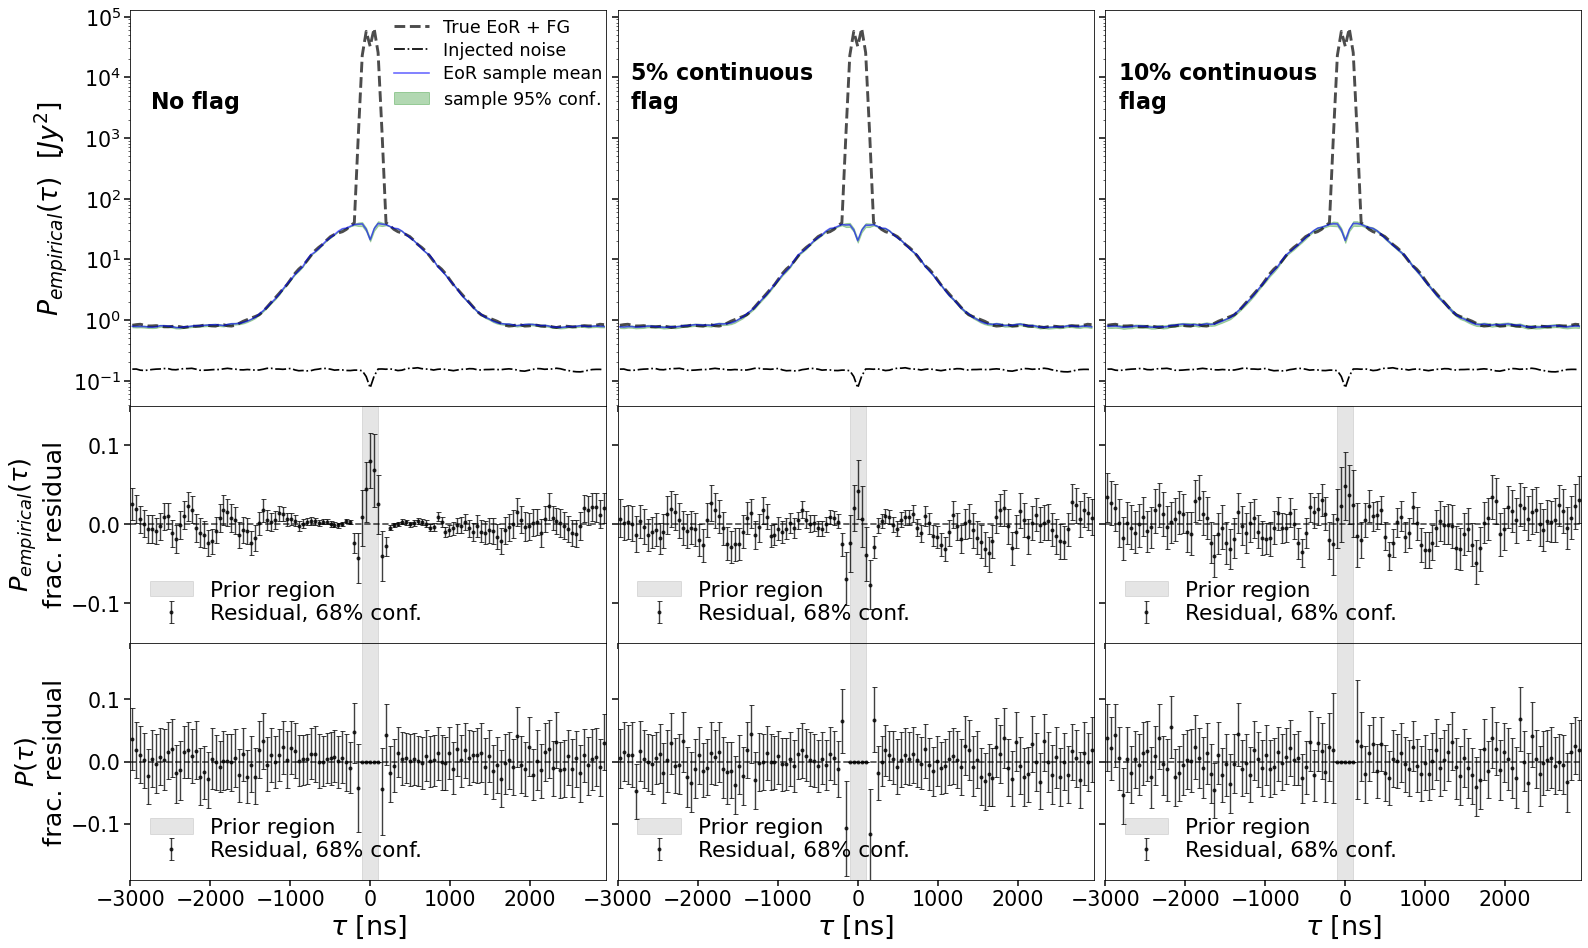

In [92]:
# BIG TRIPLE FIGURE COMPARISON
fig, axs = plt.subplots(3,3,figsize=(26,16), sharex=True, gridspec_kw={'hspace':0, 'wspace':0.025,'height_ratios':[1,0.6,0.6]})

ax1 = axs[0,0]
ax2 = axs[1,0]
ax3 = axs[2,0]

name = 'run5'
savfol = 'Gibbs-eig-runs/'
cr_store = np.load(savfol+'cr-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
amp_store = np.load(savfol+'amps-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
pSnoise = naivePS(noiseS)

Niter=800
flagtag = r'$\bf{No~flag}$'

fsb = 8.1
lwb = 0.5

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + FG', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'sample 95$\%$ conf.')

erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')

erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

ax1.legend(frameon=False, fontsize=9.5+fsb, labelspacing=0.3, bbox_to_anchor=(0.52,1.02))
ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(length=6 , width=1.5,labelsize=12.5+fsb)

ax1.text(-2750,3e3, flagtag, fontsize=14+fsb)
# ax1.text(-2850,2e2, r'$\bf{15Jy~point~source~cut}$', fontsize=15+fsb)

ax1.set_ylabel(r'$P_{empirical}(\tau) ~~[Jy^2]$', fontsize=18.5+fsb)
ax2.set_ylabel(r'$P_{empirical}(\tau)$' +'\n' + 'frac. residual', fontsize=17.5+fsb)
ax3.set_ylabel(r'$P(\tau)$' +'\n' + 'frac. residual', fontsize=17.5+fsb)
ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(length=6 , width=1.5, labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)



name = 'run4'
savfol = 'Gibbs-eig-runs/'
cr_store = np.load(savfol+'cr-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
amp_store = np.load(savfol+'amps-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
pSnoise = naivePS(noiseS)

Niter=800
flagtag = r'$\bf{5\%~continuous}$'+'\n'+r'$\bf{flag}$'

ax1 = axs[0,1]
ax2 = axs[1,1]
ax3 = axs[2,1]

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + Foreground', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'EoR sample 95$\%$ conf.')


erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')

erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

# ax1.legend(frameon=False, fontsize=14.5+fsb, labelspacing=0.3, loc='upper right')
ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(length=6 , width=1.5, labelsize=12.5+fsb, labelleft=False)

ax1.text(-2845,3e3, flagtag, fontsize=14+fsb)

ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(length=6 , width=1.5, labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)

name = 'run3'
savfol = 'Gibbs-eig-runs/'
cr_store = np.load(savfol+'cr-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
amp_store = np.load(savfol+'amps-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
pSnoise = naivePS(noiseS)

Niter=800
flagtag = r'$\bf{10\%~continuous}$'+'\n'+r'$\bf{flag}$'

ax1 = axs[0,2]
ax2 = axs[1,2]
ax3 = axs[2,2]

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + Foreground', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'EoR sample 95$\%$ conf.')


erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(length=6 , width=1.5, labelsize=12.5+fsb, labelleft=False)

ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')
    
ax1.text(-2845,3e3, flagtag, fontsize=14+fsb)
# ax1.text(-2850,2e2, r'$\bf{15Jy~point~source~cut}$', fontsize=15+fsb)

ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(length=6 , width=1.5, labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)

# plt.tight_layout()
plt.savefig('figs/Gibbs/flags-em-comparison.pdf', bbox_inches='tight')

In [77]:
bl.shape

(1200, 120)

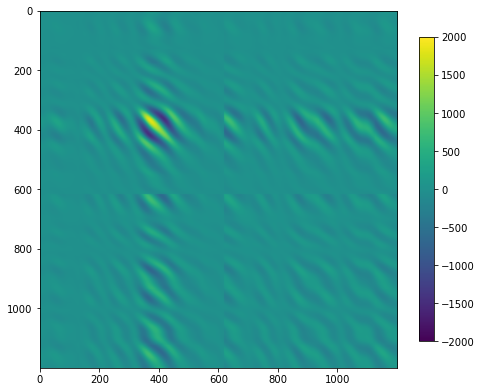

In [85]:
fig, ax= plt.subplots(figsize=(8,8))
plt.imshow(np.cov(bl).real, vmin=-2000, vmax=2000)
plt.colorbar(shrink=0.7)

In [87]:
np.save('pointsources_Gibbspaper.npy',bl)
np.save('pointsource-timecov_Gibbspaper.npy', np.cov(bl))

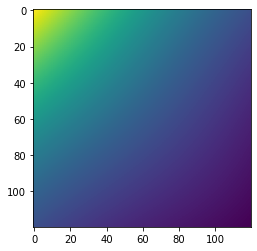

In [90]:
plt.imshow(np.cov(bl.T).real)